<a href="https://colab.research.google.com/github/mirpouya/Diabeteic-Retinopathy-project---Western-University/blob/main/densenet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip uninstall tensorflow-cloud -y
!pip install tensorflow_datasets==4.0.1

import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
#from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import datetime

import scipy
import gc

#try:
#    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#    print('Device:', tpu.master())
#    tf.config.experimental_connect_to_cluster(tpu)
#    tf.tpu.experimental.initialize_tpu_system(tpu)
#    strategy = tf.distribute.experimental.TPUStrategy(tpu)
#except:
#    strategy = tf.distribute.get_strategy()
#print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)
print(tfds.__version__)




# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Found existing installation: tensorflow-cloud 0.1.14
Uninstalling tensorflow-cloud-0.1.14:
  Successfully uninstalled tensorflow-cloud-0.1.14
     |████████████████████████████████| 3.5 MB 890 kB/s            
     |████████████████████████████████| 129 kB 56.2 MB/s            
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.15.0
    Uninstalling absl-py-0.15.0:
      Successfully uninstalled absl-py-0.15.0
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.3.0
    Uninstalling tensorflow-datasets-4.3.0:
      Successfully uninstalled tensorflow-datasets-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tfx-bsl 1.5.0 r

# Load And Split

In [ ]:
# Custom variables
manual_dir = r'/kaggle/input/retinopathy-btgraham300/tensorflow_datasets'

#AUTOTUNE = tf.data.experimental.AUTOTUNE
#BATCH_SIZE = 16 * strategy.num_replicas_in_sync
#IMAGE_SIZE = [300, 300]
#EPOCHS = 25

In [ ]:
# Configure dataset
(ds_train, ds_val, ds_test), ds_info = \
tfds.load('diabetic_retinopathy_detection/btgraham-300:3.0.0',
          split=['train', 'validation', 'test'],
          download=False,data_dir=manual_dir, with_info=True,
          shuffle_files=False, as_supervised=False)

2022-01-29 09:06:58.887866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 09:06:58.982574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 09:06:58.983274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 09:06:58.986053: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='diabetic_retinopathy_detection',
    version=3.0.0,
    description='A large set of high-resolution retina images taken under a variety of imaging conditions.',
    homepage='https://www.kaggle.com/c/diabetic-retinopathy-detection/data',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
        'name': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=88712,
    splits={
        'sample': 10,
        'test': 42670,
        'train': 35126,
        'validation': 10906,
    },
    supervised_keys=None,
    citation="""@ONLINE {kaggle-diabetic-retinopathy,
        author = "Kaggle and EyePacs",
        title  = "Kaggle Diabetic Retinopathy Detection",
        month  = "jul",
        year   = "2015",
        url    = "https://www.kaggle.com/c/diabetic-retinopathy-detection/data"
    }""",
    redistribution_info=,
)



In [ ]:
#datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
#from tensorflow.keras.utils import Sequence
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.keras import balanced_batch_generator

#class BalancedDataGenerator(Sequence):
#    """ImageDataGenerator + RandomOversampling"""
#    def __init__(self, x, y, datagen, batch_size=32):
#        self.datagen = datagen
#        self.batch_size = min(batch_size, x.shape[0])
#        datagen.fit(x)
#        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
#        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])

#    def __len__(self):
#        return self.steps_per_epoch

#    def __getitem__(self, idx):
#        x_batch, y_batch = self.gen.__next__()
#        x_batch = x_batch.reshape(-1, *self._shape[1:])
#        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [ ]:
#def map_image(tensor):
#    return tensor['label']

In [ ]:
#[i for i in ds_train.map(map_image)]

In [ ]:
#balanced_gen = BalancedDataGenerator(
#    [img for img in ds_train.map(lambda tensor:tensor['image'])],
#    [label for label in ds_train.map(lambda tensor:tensor['label'])],
#    datagen, batch_size=32)

In [ ]:
#for i in ds_train.take(1):
#    print(i)
#    print("Espacio")
#    print(i['image'].numpy())

# EDA

2022-01-29 09:07:01.322677: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


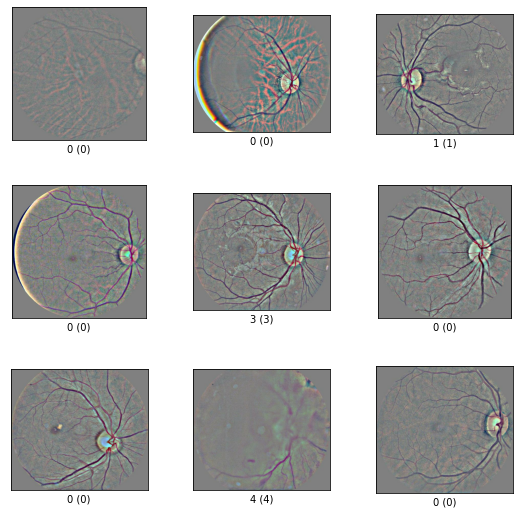

In [ ]:
vis = tfds.visualization.show_examples(ds_train, ds_info)

In [ ]:
for tensor in ds_train.take(1):
    image=tensor['image'].numpy()
    label=tensor['label'].numpy()

Etiqueta:  0


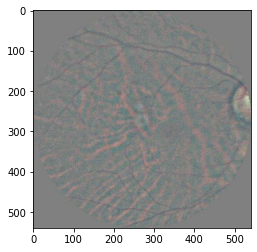

In [ ]:
print("Etiqueta: ",label)
plt.imshow(image);

(0, 25810) (1, 2443) (2, 5292) (3, 873) (4, 708)


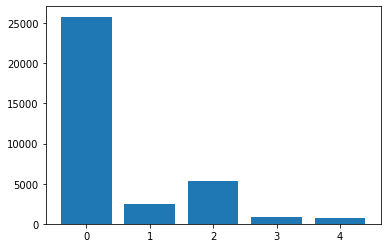

In [ ]:
label_list = [tensor['label'] for tensor in ds_train.as_numpy_iterator()]
unique, counts = np.unique(label_list, return_counts=True)
plt.bar(unique, counts)
print(*zip(unique, counts))

# Class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

class_weights = compute_class_weight('balanced', np.unique(label_list), label_list)
sample_weights = compute_sample_weight('balanced', label_list)

class_weights_dict = dict(enumerate(class_weights))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4], y=[0, 0, 1, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 1, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 1, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 3, 1, 0, 4, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 1, 2, 2, 0, 0, 4, 2, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 2, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 4, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 2, 0, 1, 0, 0, 

In [ ]:
len(sample_weights)

35126

In [ ]:
y = np.bincount(label_list)
ii = np.nonzero(y)[0]
list_zip =[*zip(ii,y[ii])]
list_zip

[(0, 25810), (1, 2443), (2, 5292), (3, 873), (4, 708)]

In [ ]:
y

array([25810,  2443,  5292,   873,   708])

In [ ]:
[y[i]*class_weights[i] for i in range(4)]


[7025.2, 7025.2, 7025.2, 7025.2]

# Reject undersampling

In [ ]:
#def count(counts, tensor):
#  labels = tensor['label']

#  class_1 = labels == 1
#  class_1 = tf.cast(class_1, tf.int32)

#  class_0 = labels == 0
#  class_0 = tf.cast(class_0, tf.int32)

#  class_2 = labels == 2
#  class_2 = tf.cast(class_2, tf.int32)

#  class_3 = labels == 3
#  class_3 = tf.cast(class_3, tf.int32)

#  class_4 = labels == 4
#  class_4 = tf.cast(class_4, tf.int32)

#  counts['class_0'] += tf.reduce_sum(class_0)
#  counts['class_1'] += tf.reduce_sum(class_1)
#  counts['class_2'] += tf.reduce_sum(class_2)
#  counts['class_3'] += tf.reduce_sum(class_3)
#  counts['class_4'] += tf.reduce_sum(class_4)

#  return counts

In [ ]:
#counts = ds_train.take(35126).reduce(
#    initial_state={'class_0': 0, 'class_1': 0, 'class_2': 0, 'class_3': 0, 'class_4': 0},
#    reduce_func = count)
#
#counts = np.array([counts['class_0'].numpy(),
#                   counts['class_1'].numpy(),
#                   counts['class_2'].numpy(),
#                   counts['class_3'].numpy(),
#                   counts['class_4'].numpy()]).astype(np.float32)

#fractions = counts/counts.sum()
#print(*fractions)

In [ ]:
#def class_func(tensor): #Aux func for resampling 'cause the data is imbalance
#    return tensor['label']

In [ ]:
#resampler = tf.data.experimental.rejection_resample(
#    class_func, target_dist=[0.2,0.2,0.2,0.2,0.2], initial_dist=fractions)

In [ ]:
#resample_ds = ds_train.apply(resampler).take(3800)

In [ ]:
#balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

In [ ]:
#label_list_balanced = [tensor['label'].numpy() for tensor in balanced_ds.take(3800)]
#unique, counts = np.unique(label_list_balanced, return_counts=True)
#plt.bar(unique, counts)
#print(*zip(unique, counts))

# Preprocesing

In [ ]:
def transform_images(row, size, reescale=True):
    x_train = tf.image.resize(row['image'], (size, size))
    if reescale:
        x_train = x_train  / 255
    return x_train, tf.one_hot(row['label'], depth=5)
def transform_images_complete(row, size):
    x_train = tf.image.resize(row['image'], (size, size))
    x_train = x_train  / 255
    return x_train, tf.one_hot(row['label'], depth=5), row['name']

ds_train = ds_train.map(lambda row:transform_images(row, 400))
#ds_train = resample_ds.map(lambda _, row:transform_images(row, 400))
ds_val = ds_val.map(lambda row:transform_images(row, 400))
#ds_test_all = ds_test.map(lambda row:transform_images_complete(row, 300))
ds_test = ds_test.map(lambda row:transform_images(row, 400, reescale=True))

In [ ]:
print("Num classes: " + str(ds_info.features['label'].num_classes))
print("Class names: " + str(ds_info.features['label'].names))

Num classes: 5
Class names: ['0', '1', '2', '3', '4']


In [ ]:
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(ds_train).numpy()
print("Num training images: " + str(NUM_TRAIN_IMAGES))

NUM_VAL_IMAGES = tf.data.experimental.cardinality(ds_val).numpy()
print("Num validating images: " + str(NUM_VAL_IMAGES))

NUM_TEST_IMAGES = tf.data.experimental.cardinality(ds_test).numpy()
print("Num testing images: " + str(NUM_TEST_IMAGES))

Num training images: 35126
Num validating images: 10906
Num testing images: 42670


In [ ]:
#ds_train = ds_train.cache()
ds_train = ds_train.shuffle(1000)
ds_train = ds_train.batch(32)
#ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

#ds_val = ds_val.cache()
ds_val = ds_val.shuffle(1000)
ds_val = ds_val.batch(32)
#ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

#ds_test = ds_test.cache()
ds_test = ds_test.batch(32)
#ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
for i in ds_train.take(1):
    print(i)

(<tf.Tensor: shape=(32, 400, 400, 3), dtype=float32, numpy=
array([[[[0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         ...,
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608]],

        [[0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         ...,
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608]],

        [[0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         ...,
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608]],

        ...,

        [[0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608]

# Build Model

In [ ]:


from tensorflow.keras.layers import Input # Input Layer
from tensorflow.keras.applications import DenseNet121 # Keras Application
from tensorflow.keras.layers import Dense # Dense Layer (Fully connected)
from tensorflow.keras.models import Model # Model Structure



input_shape=(400, 400, 3)

img_input = Input(shape=input_shape)
base_model = DenseNet121(include_top=False,
                         input_tensor=img_input,
                         input_shape=input_shape,
                         pooling="max",
                         weights='imagenet')
base_model.trainable = True
x = base_model.output
predictions = Dense(5,
                    activation="softmax",
                    name="predictions")(x)
model = Model(inputs=img_input,
              outputs=predictions)

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #by default learning_rate=0.001
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="cat_acc"),tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.Precision(name='precision')]
)

# Train Model

In [ ]:
history = model.fit(
    ds_train,
    epochs=20,
    #steps_per_epoch=NUM_TRAIN_IMAGES/32, los batchs de 32 ya han sido asignados arriba
    validation_data=ds_val,
    #validation_steps=NUM_VAL_IMAGES/32,
    class_weight=class_weights_dict,
    shuffle=True,
    callbacks=[
        #tf.keras.callbacks.EarlyStopping(patience=11, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(patience=4, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(filepath='bestmodel.h5',
                                          verbose=1, save_best_only=True)
    ]
)

Epoch 1/20


2022-01-29 09:08:11.044408: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1097/1098 [============================>.] - ETA: 0s - loss: 2.0308 - cat_acc: 0.3686 - auc: 0.7212 - recall: 0.3247 - precision: 0.3821

2022-01-29 09:18:50.635647: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


1098/1098 [==============================] - 738s 653ms/step - loss: 2.0301 - cat_acc: 0.3687 - auc: 0.7212 - recall: 0.3248 - precision: 0.3822 - val_loss: 1.3652 - val_cat_acc: 0.4454 - val_auc: 0.7997 - val_recall: 0.3800 - val_precision: 0.4816

Epoch 00001: val_loss improved from inf to 1.36520, saving model to bestmodel.h5
Epoch 2/20
1098/1098 [==============================] - 715s 648ms/step - loss: 1.2135 - cat_acc: 0.4788 - auc: 0.8179 - recall: 0.4107 - precision: 0.5146 - val_loss: 0.9369 - val_cat_acc: 0.6469 - val_auc: 0.9003 - val_recall: 0.6043 - val_precision: 0.6763

Epoch 00002: val_loss improved from 1.36520 to 0.93694, saving model to bestmodel.h5
Epoch 3/20
1098/1098 [==============================] - 720s 652ms/step - loss: 0.8806 - cat_acc: 0.5639 - auc: 0.8691 - recall: 0.4978 - precision: 0.6030 - val_loss: 0.8839 - val_cat_acc: 0.6481 - val_auc: 0.9038 - val_recall: 0.5896 - val_precision: 0.6859

Epoch 00003: val_loss improved from 0.93694 to 0.88391, saving

# Plot model training

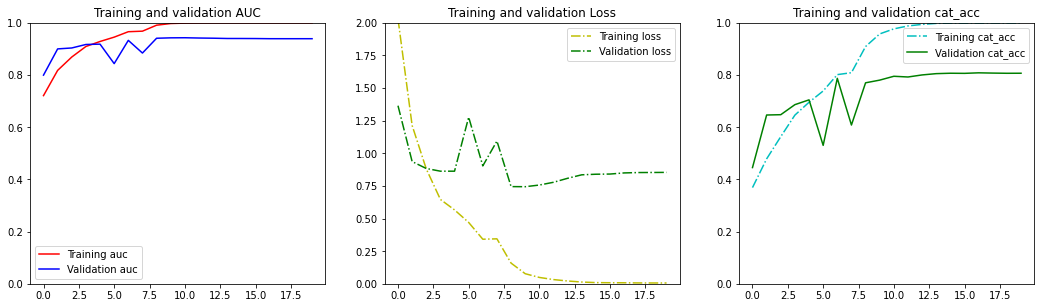

In [ ]:
# Se realiza un gráfico de la precisión de entrenamiento y validación
import matplotlib.pyplot as plt
auc = history.history['auc']
val_auc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
cat_acc = history.history['cat_acc']
val_cat_acc = history.history['val_cat_acc']

epochs = range(len(auc))
plt.figure(figsize=(18, 4.8))
plt.subplot(1,3,1)
plt.plot(epochs, auc, 'r', label='Training auc')
plt.plot(epochs, val_auc, 'b', label='Validation auc')
plt.ylim(0, 1)
plt.title('Training and validation AUC')
plt.legend(loc=0)

plt.subplot(1,3,2)
plt.plot(epochs, loss, 'y-.', label='Training loss')
plt.plot(epochs, val_loss, 'g-.', label='Validation loss')
plt.title('Training and validation Loss')
plt.ylim(0, 2)
plt.legend(loc=0)

plt.subplot(1,3,3)
plt.plot(epochs, cat_acc, 'c-.', label='Training cat_acc')
plt.plot(epochs, val_cat_acc, 'g', label='Validation cat_acc')
plt.title('Training and validation cat_acc')
plt.ylim(0, 1)
plt.legend(loc=0)



plt.show();

# Only use the best weights for the model.

In [ ]:
best_model = tf.keras.models.load_model('bestmodel.h5')

# Preds and Evaluation

In [ ]:
preds = best_model.predict(ds_test, verbose=1)

1333/1334 [============================>.] - ETA: 0s

2022-01-29 13:14:41.317919: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-29 13:14:41.339350: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-29 13:14:41.353366: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


1334/1334 [==============================] - 186s 137ms/step


In [ ]:
evaluation_model = best_model.evaluate(ds_test, verbose=1)

1334/1334 [==============================] - 202s 149ms/step - loss: 0.7872 - cat_acc: 0.7710 - auc: 0.9379 - recall: 0.7587 - precision: 0.7823


In [ ]:
print(*zip(evaluation_model,['loss','cat_acc','auc','recall','precision']))

(0.787187933921814, 'loss') (0.7710101008415222, 'cat_acc') (0.937937319278717, 'auc') (0.758682906627655, 'recall') (0.7822966575622559, 'precision')


In [ ]:
preds[1]

array([9.9965918e-01, 4.2363157e-05, 2.9850169e-04, 3.3118208e-09,
       2.9895419e-11], dtype=float32)

In [ ]:
preds = [np.argmax(pred) for pred in preds]

In [ ]:
len(preds)

42670

In [ ]:
ds_test = ds_test.unbatch()

In [ ]:
actuals = [np.argmax(row[1]) for row in ds_test.as_numpy_iterator()]

In [ ]:
len(actuals)

42670

In [ ]:
print("preds:",preds[:30])
print("trues:",actuals[:30])

preds: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 1, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0]
trues: [0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
sample_weights = compute_sample_weight('balanced', actuals)

In [ ]:
m = tfa.metrics.CohenKappa(num_classes=5, sparse_labels=True, weightage="quadratic")
#m = tf.keras.metrics.Accuracy()
m.update_state(actuals, preds, sample_weight=sample_weights)
print('Final result: ', m.result().numpy())

Final result:  0.72014236


In [ ]:
from sklearn.metrics import (mean_squared_error,confusion_matrix, plot_confusion_matrix, f1_score)
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(actuals, preds, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.87      0.90      0.88     31403
     class 1       0.19      0.14      0.16      3042
     class 2       0.54      0.54      0.54      6282
     class 3       0.40      0.40      0.40       977
     class 4       0.62      0.54      0.58       966

    accuracy                           0.77     42670
   macro avg       0.52      0.50      0.51     42670
weighted avg       0.76      0.77      0.76     42670



In [ ]:
confusion_matrix(actuals, preds)

array([[28157,  1494,  1607,    31,   114],
       [ 2041,   439,   553,     7,     2],
       [ 1927,   410,  3390,   418,   137],
       [   48,    13,   455,   393,    68],
       [   67,     8,   243,   128,   520]])